# Correlation and Relationships

Aktuell (im letzten NOtebook) stehen die Werte untereinander (eine Zeile pro Measure). Um zu testen, ob "Sicherheit" mit "Lebenszufriedenheit" korreliert, müssen diese als Spalten nebeneinander stehen. Wir müssen den Datensatz also umformen ("pivoten").

-> Bevor wir eine Zahl berechnen, müssen wir die Daten sehen. Ist der Zusammenhang linear? Gibt es "Wolken"?

## 1. Setup & Daten Laden

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

In [29]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

In [57]:
current_dir = Path.cwd()
data_path = current_dir.parent / 'data' / 'oecd_snapshot_latest.csv'

try:
    df = pd.read_csv(data_path)
    print("Daten erfolgreich geladen.")

    df = df.loc[:, ~df.columns.duplicated()]
        
except FileNotFoundError:
    print(f"FEHLER: Datei nicht gefunden unter {data_path}")

Daten erfolgreich geladen.


## 2. Daten Transformation

In [32]:
target_sex = 'Total' if 'Total' in df['sex'].unique() else '_T'
target_age = 'Total' if 'Total' in df['age'].unique() else '_T'

In [59]:
mask = (df['sex'] == target_sex) & (df['age'] == target_age)
df_filtered = df[mask].copy()

In [60]:
df_pivot = df_filtered.pivot_table(
    index='reference_area', 
    columns='measure', 
    values='value',
    aggfunc='mean' 
)

print(f"\nDatensatz transformiert. Anzahl Länder: {len(df_pivot)}")


Datensatz transformiert. Anzahl Länder: 47


### 3. VARIABLEN SELEKTION

In [ ]:
# Zielvariable aus Notebook 2
target_var = "Feeling safe at night"

# Verfügbare Indikatoren prüfen
print(df_pivot.columns.tolist())


Verfügbare Indikatoren:
['Access to green space', 'Adult literacy skills', 'Adult numeracy skills', 'Adults with low literacy skills', 'Adults with low numeracy skills', 'Average annual gross earnings', 'Deaths from suicide, alcohol, drugs', 'Difficulty making ends meet', 'Employment rate', 'Equivalised liquid financial assets below three months of the annual national relative income poverty line', 'Exposed to air pollution', 'Exposure to extreme temperature', 'Feeling lonely', 'Feeling safe at night', 'Feelings of physical pain', 'Full-time employees earning less than two-thirds of gross median earnings', 'Gender gap in working hours', 'Gender wage gap', 'Having a say in government', 'Homicides', 'Household disposable income below the relative income poverty line', 'Households and NPISHs net adjusted disposable income per capita', 'Households living in overcrowded conditions', 'Households with internet access at home', 'Housing affordability', 'Housing cost overburden', 'Inability to

In [63]:
potential_drivers = [
    "Life satisfaction",
    "Homicides",
    "Difficulty making ends meet",
    "Median net wealth",
    "Social support",
    "Voter turnout",
    "Self-reported depression",
    "Access to green space"
]

### Hypothesen zur Variablenwahl

Aus der Vielzahl der OECD-Indikatoren haben wir gezielt jene ausgewählt, die theoretisch einen starken Einfluss auf das subjektive Sicherheitsgefühl (*"Feeling safe at night"*) haben könnten. Wir decken damit vier Dimensionen ab:

1.  **Objektive Realität (`Homicides`):**
    * *Hypothese:* Wir erwarten eine starke **negative Korrelation**. In Ländern mit vielen Tötungsdelikten (objektive Gefahr) sollten sich die Menschen auch unsicherer fühlen. Falls nicht, wäre das eine spannende "Diskrepanz zwischen Wahrnehmung und Realität".

2.  **Ökonomische Prekarität (`Difficulty making ends meet`, `Median net wealth`):**
    * *Hypothese:* Finanzielle Unsicherheit korreliert oft mit Wohngegenden, die als weniger sicher wahrgenommen werden. Wer schwer über die Runden kommt, fühlt sich oft generell vulnerabler (**Negative Korrelation**).

3.  **Sozialer Zusammenhalt (`Social support`, `Voter turnout`):**
    * *Hypothese:* "Social Support" misst, ob man jemanden hat, auf den man zählen kann. Ein starkes soziales Netz sollte das Angstgefühl senken (**Positive Korrelation**). Eine hohe Wahlbeteiligung deutet zudem auf Vertrauen in staatliche Institutionen (Polizei/Justiz) hin.

4.  **Umwelt & Psyche (`Access to green space`, `Self-reported depression`):**
    * *Hypothese:* Zugang zu Grünflächen steht oft für städtebauliche Qualität. Dunkle, betonierte Ecken machen Angst; Parks und gepflegte Plätze schaffen Sicherheit (Broken-Windows-Theorie). Umgekehrt könnte eine hohe Depressionsrate die Weltwahrnehmung ins Negative (Unsichere) verzerren.

In [64]:
# intersection, um Tippfehler abzufangen
cols_to_use = [target_var] + potential_drivers
# nur die Spalten nehmen, die auch wirklich da sind
valid_cols = df_pivot.columns.intersection(cols_to_use)

df_corr = df_pivot[valid_cols].copy()

# alle Daten -> Zahlenformat, alles was kein Text ist -> NaN
for col in df_corr.columns:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

# Wir löschen Länder, die in diesen Spalten NaNs haben (Listwise Deletion) -> Korrelation braucht vollständige Paare
df_corr = df_corr.dropna()

print(f"\nAnalyse-Tabelle erstellt mit {df_corr.shape[0]} Ländern.")
df_corr.head()


Analyse-Tabelle erstellt mit 24 Ländern.


measure,Access to green space,Difficulty making ends meet,Feeling safe at night,Homicides,Life satisfaction,Median net wealth,Self-reported depression,Social support,Voter turnout
reference_area,,,,,,,,,
Austria,77.252527,13.1,82.546060,0.4,7.575,189148.0,6.075,89.024267,80.807063
Belgium,57.652810,17.2,68.829203,0.7,7.550,343656.0,9.225,91.298786,87.420000
Croatia,58.592954,19.8,77.833333,0.7,7.125,151212.0,8.875,90.838590,62.300000
Czechia,86.247004,14.2,76.741255,0.5,7.425,193239.0,4.300,93.843487,73.043907
Denmark,59.497138,12.8,87.161465,0.5,7.575,60466.0,9.175,93.867644,84.160000


## 4. Visuelle Prüfung

In [68]:
x_val = "Life satisfaction"
y_val = target_var

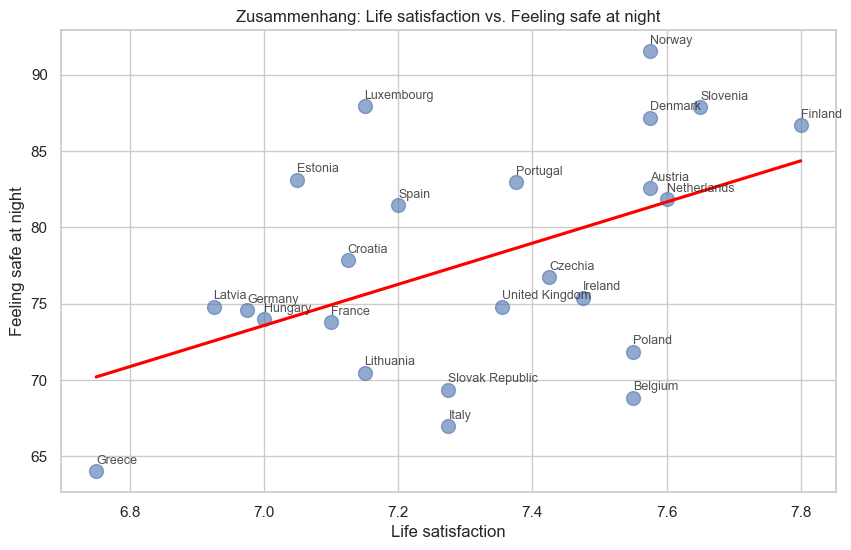

In [69]:
if x_val in df_corr.columns and y_val in df_corr.columns:
    plt.figure(figsize=(10, 6))
    
    sns.regplot(data=df_corr, x=x_val, y=y_val, ci=None, 
                scatter_kws={'s': 100, 'alpha': 0.6}, 
                line_kws={"color": "red"})
    
    for i in range(df_corr.shape[0]):
        plt.text(
            df_corr[x_val].iloc[i], 
            df_corr[y_val].iloc[i]+0.5, 
            df_corr.index[i], 
            fontsize=9, 
            alpha=0.8
        )
        
    plt.title(f"Zusammenhang: {x_val} vs. {y_val}")
    plt.xlabel(x_val)
    plt.ylabel(y_val)
    plt.show()
    
else:
    print(f"Variable {x_val} nicht im Datensatz gefunden.")

## 5. Korrelation: Pearson vs. Spearman

Wir berechnen Spearman, da wir in Notebook 2 Ausreißer gesehen haben (robuster Ansatz)

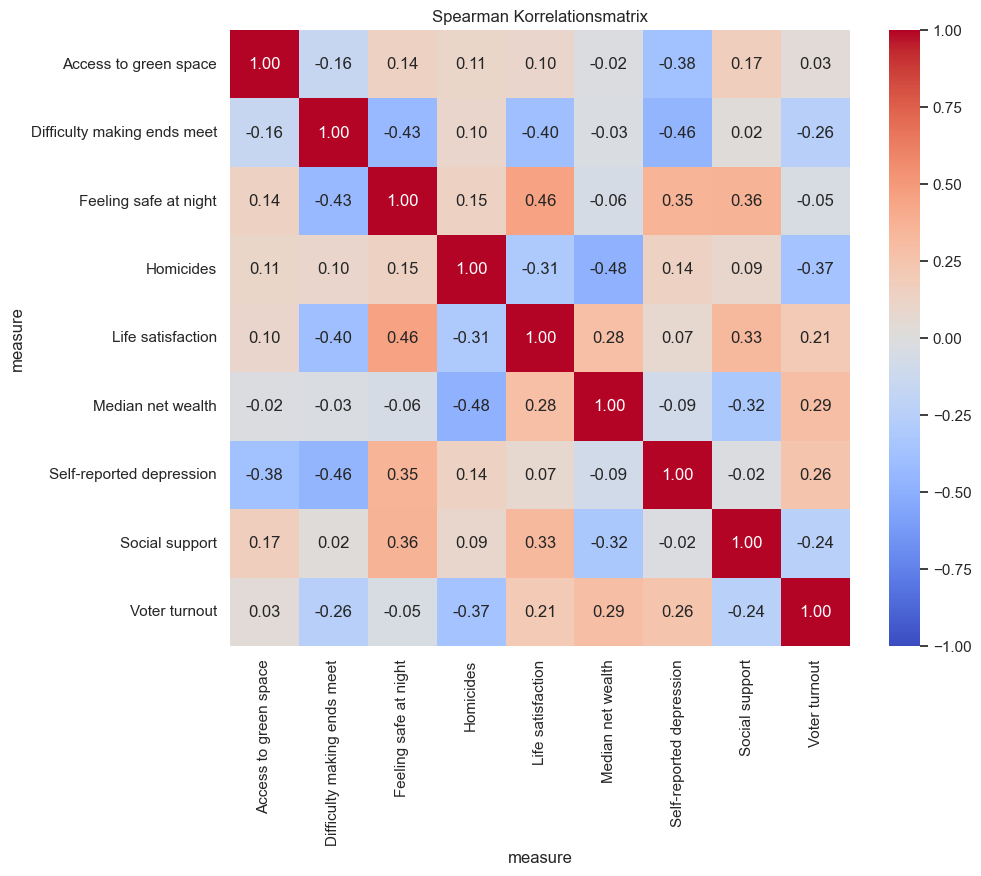

In [72]:
corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Spearman Korrelationsmatrix")
plt.show()

## 6. Signifikanztest

In [74]:
v1 = target_var
v2 = "Life satisfaction"

In [76]:
if v2 in df_corr.columns:
    corr, p_val = stats.spearmanr(df_corr[v1], df_corr[v2])

    print(f"Spearman Test: '{v1}' vs '{v2}'")
    print(f"Korrelation (rho): {corr:.4f}")
    print(f"p-Wert: {p_val:.6f}")

    if p_val < 0.05:
        print("Ergebnis: Statistisch signifikant! (Wir verwerfen H0)")
    else:
        print("Ergebnis: Nicht signifikant.")

Spearman Test: 'Feeling safe at night' vs 'Life satisfaction'
Korrelation (rho): 0.4603
p-Wert: 0.023624
Ergebnis: Statistisch signifikant! (Wir verwerfen H0)
